In [2]:
import pandas as pd
import pyarrow as pa
import numpy as np
from utils import load_saved_data, get_connection
#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut

In [3]:
df = load_saved_data()
df

,created_date,closed_date,agency,complaint_type,status,resolution_action_updated_date,latitude,longitude,descriptor,resolution_description,due_date
0,2018-06-11 12:12:00,2017-11-27 00:00:00,DEP,FATF,Pending,2017-11-27 00:00:00,40.590094,-73.932163,None,None,NaT
1,2018-05-11 11:51:00,2017-03-10 00:00:00,DEP,FATF,Pending,2017-03-10 00:00:00,40.734382,-73.864309,None,None,NaT
2,2018-05-01 09:19:00,2017-07-19 00:00:00,DEP,FATF,Pending,2017-07-19 00:00:00,40.734605,-73.864774,None,None,NaT
3,2018-04-27 09:21:00,2017-09-21 00:00:00,DEP,FATF,Pending,2017-09-21 00:00:00,40.778421,-73.894593,None,None,NaT
4,2018-03-14 00:00:00,2017-03-15 15:30:00,DOHMH,Food Poisoning,Pending,2017-03-15 15:30:00,40.814362,-73.913257,3 or More,Callers should contact the DOHMH Foodborne Ill...,2018-03-28 12:47:14
...,...,...,...,...,...,...,...,...,...,...,...
199995,2017-12-04 08:25:56,2017-12-04 09:53:03,DHS,Homeless Person Assistance,Closed,2017-12-04 09:53:03,40.882710,-73.881246,N/A,The mobile outreach response team offered serv...,2017-12-04 11:51:57
199996,2017-12-04 08:25:32,2017-12-11 10:26:58,DOT,Street Condition,Closed,2017-12-11 10:26:58,40.664933,-73.931474,Plate Condition - Noisy,The Department of Transportation inspected the...,2017-12-14 08:25:32
199997,2017-12-04 08:25:32,2017-12-08 13:05:45,DOT,Street Sign - Dangling,Closed,2017-12-08 13:05:45,40.801400,-73.954222,"No Parking, Standing, Stopping",The Department of Transportation has completed...,2017-12-21 08:29:06
199998,2017-12-04 08:25:00,2017-12-06 12:00:00,DSNY,Missed Collection (All Materials),Closed,2017-12-06 12:00:00,40.827830,-73.906312,1 Missed Collection,The Department of Sanitation investigated this...,NaT


In [18]:
df["hours_to_complete"]<0

0          True
1          True
2          True
3          True
4          True
          ...  
199995    False
199996    False
199997    False
199998    False
199999    False
Name: hours_to_complete, Length: 200000, dtype: bool

In [21]:
time_to_complete = df["closed_date"] - df["created_date"]
df['hours_to_complete'] = time_to_complete.dt.total_seconds()//(3600)
# df= df.drop("hours_to_update", axis=1)
df = df.drop(df[df["hours_to_complete"]<0].index, axis=0)

<Axes: title={'center': 'Number of Unclosed Requests by Agency'}, xlabel='Agency', ylabel='Unclosed Request Count'>

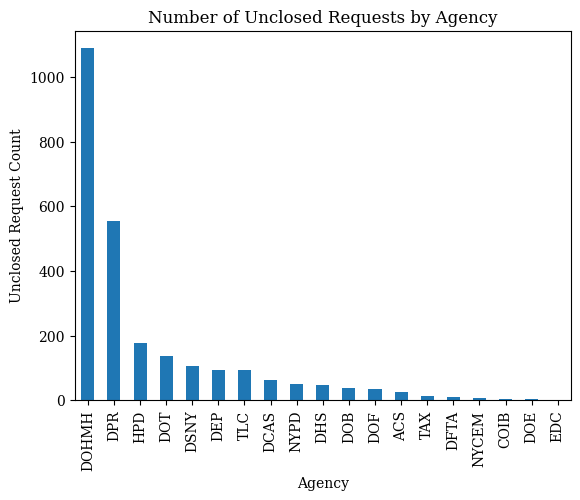

In [27]:
unclosed = df[df["status"]!="Closed"]["agency"].value_counts()
unclosed.plot.bar(title="Number of Unclosed Requests by Agency", xlabel="Agency", ylabel="Unclosed Request Count")

In [30]:
df = df.drop(df[df["status"]!="Closed"].index, axis=0)